In [ ]:
### Import Libraries
import pickle
from matplotlib import pyplot as plt
import numpy as np
from pyshred.models import SHRED # import SHRED
from pyshred.datasets import load_plasma # import plasma dataset

%load_ext autoreload
%autoreload 2
from pyshred_pypi_helper import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
### Load Plasma Data
plasma_data = load_plasma()
# Get number of timesteps (size of last dimension of array)
timesteps = plasma_data['Jex'].shape[-1]
# Selected number of hidden timesteps evaluate forecasting
test_timesteps = 50
training_timesteps = timesteps - test_timesteps
# Setup input dictionary 
data_Jex = plasma_data['Jex'][:,:,:-test_timesteps]
data_Jey = plasma_data['Jey'][:,:,:-test_timesteps]
data_Jez = plasma_data['Jez'][:,:,:-test_timesteps]
data = {
    'Jex' : data_Jex,
    'Jey' : data_Jey,
    'Jez' : data_Jez,
}
print('total timesteps:', timesteps)
print('training timesteps:', training_timesteps)
print('training data:')
for key, value in data.items():
    print(f"{key}: {value.shape}")

total timesteps: 2000
training timesteps: 1950
training data:
Jex: (50, 60, 1950)
Jey: (50, 60, 1950)
Jez: (50, 60, 1950)


In [84]:
### Load Sensor Data
# mobile sensor trajectory list
Jez_mobile_clockwise_perimeter_walk_cw = perimeter_walk(height = data_Jez.shape[0], width = data_Jez.shape[1], timesteps = data_Jez.shape[2], clockwise=True)
Jez_mobile_clockwise_perimeter_walk_ccw = perimeter_walk(height = data_Jez.shape[0], width = data_Jez.shape[1], timesteps = data_Jez.shape[2], clockwise=False)
# Create sensors dictionary
sensor = {
    'Jex' : 3, # random stationary sensors
    'Jey' : [(0,0), (49,59)], # selected stationary sensors
    'Jez' : [Jez_mobile_clockwise_perimeter_walk_cw, Jez_mobile_clockwise_perimeter_walk_ccw] # mobile sensors
}

In [85]:
### Save dictionaries as pickle files
with open('data.pkl','wb') as file:
    pickle.dump((data), file)
with open('sensor.pkl','wb') as file:
    pickle.dump((sensor), file)

In [ ]:
### Initialize and Fit SHRED
# Default

shred = SHRED(sequence='LSTM', decoder='SDN')
val_errors,  sensor_forecast_errors = shred.fit(data = 'data.pkl', sensors = 'sensor.pkl', num_epochs=100) # by default: n_components = 20
# Custom
# lags = 40
# num_epochs = 1000
# val_errors,  sensor_forecast_errors = shred.fit(data = data, sensors = sensor, num_epochs=num_epochs, lags=lags)

Compressing Data...
Done.

Fitting Reconstructor...


Epoch 100/100: 100%|██████████| 24/24 [00:00<00:00, 50.94batch/s, loss=0.00854, L2=0.172, val_loss=0.00844, val_L2=0.17]



Fitting Forecaster...


Epoch 100/100: 100%|██████████| 24/24 [00:00<00:00, 66.66batch/s, loss=0.00122, L2=0.064, val_loss=0.000766, val_L2=0.0515]


In [87]:
### SHRED model printout post fit()
print(shred)

SHRED(
  (_reconstructor): _SHRED(
    (_sequence_model): LSTMSequence(
      (lstm): LSTM(7, 64, num_layers=2, batch_first=True)
    )
    (_decoder_model): SDN(
      (linear1): Linear(in_features=64, out_features=350, bias=True)
      (linear2): Linear(in_features=350, out_features=400, bias=True)
      (linear3): Linear(in_features=400, out_features=67, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (_sensor_forecaster): _SHRED(
    (_sequence_model): LSTMSequence(
      (lstm): LSTM(7, 64, num_layers=2, batch_first=True)
    )
    (_decoder_model): SDN(
      (linear1): Linear(in_features=64, out_features=350, bias=True)
      (linear2): Linear(in_features=350, out_features=400, bias=True)
      (linear3): Linear(in_features=400, out_features=7, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
)


In [88]:
### Print SHRED model summary
shred.summary()

                    SHRED Model Results                     
                       Reconstructor                        
Sequence:                     LSTM
Decoder:                      SDN
Validation Error (L2):        0.170
------------------------------------------------------------
                     Sensor Forecaster                      
Sequence:                     LSTM
Decoder:                      SDN
Validation Error (L2):        0.051
No. Observations:             1950
No. Sensors:                  7
Time:                         (start: 0, end: 1949, by: 1)
Lags (timesteps):             40
Compression (components):     20



In [89]:
### Reconstructor Validation Errors & Sensor Forecaster Validation Errors at Each Epoch
print(shred.recon_validation_errors)
print(shred.forecast_validation_errors)

[0.31671607 0.29303372 0.28987807 0.28916875 0.28977746 0.28927633
 0.28895035 0.28863335 0.288938   0.2853356  0.2787396  0.27601334
 0.27252    0.27043563 0.26874742 0.26678535 0.2639662  0.26267856
 0.26059845 0.26026842 0.2585285  0.25768566 0.25698143 0.2571438
 0.2556071  0.25496143 0.2548007  0.25357145 0.25362587 0.2532154
 0.25106987 0.24989325 0.24935377 0.24769758 0.24676515 0.2465733
 0.24514368 0.24484435 0.24553207 0.24297965 0.24077164 0.23916723
 0.23921955 0.23826946 0.23572029 0.23360668 0.2323467  0.2321969
 0.22916256 0.22884633 0.22801241 0.22695673 0.22405328 0.2235525
 0.22260642 0.2234359  0.22261006 0.22111796 0.22080953 0.21827838
 0.2175339  0.21637753 0.21502857 0.2129596  0.21517853 0.21251982
 0.21094538 0.2092997  0.20929325 0.20715642 0.2055417  0.20674026
 0.20473082 0.20461345 0.20306383 0.20052525 0.19904427 0.19905205
 0.19796333 0.19796444 0.19720943 0.19666108 0.19160138 0.19242701
 0.19056594 0.18976691 0.18699321 0.18608494 0.184835   0.1839906
 

In [90]:
### Print SHRED Sensor Summary
shred.sensor_summary

row index dataset        type  \
0          0     Jex  stationary   
1          1     Jex  stationary   
2          2     Jex  stationary   
3          3     Jey  stationary   
4          4     Jey  stationary   
5          5     Jez      mobile   
6          6     Jez      mobile   

                                 location/trajectory  
0                                            (9, 31)  
1                                           (27, 23)  
2                                           (12, 35)  
3                                             (0, 0)  
4                                           (49, 59)  
5  [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5...  
6  [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0...

In [91]:
### SHRED Sensor Data
shred.sensor_data.shape

(7, 1950)

In [92]:
### Get true sensor measurements for the entire dataset (trainining + testing indices)
row0 = plasma_data['Jex'][shred.sensor_summary['location/trajectory'][0][0], shred.sensor_summary['location/trajectory'][0][1], :]
row1 = plasma_data['Jex'][shred.sensor_summary['location/trajectory'][1][0], shred.sensor_summary['location/trajectory'][1][1], :]
row2 = plasma_data['Jex'][shred.sensor_summary['location/trajectory'][2][0], shred.sensor_summary['location/trajectory'][2][1], :]
row3 = plasma_data['Jey'][shred.sensor_summary['location/trajectory'][3][0], shred.sensor_summary['location/trajectory'][3][1], :]
row4 = plasma_data['Jey'][shred.sensor_summary['location/trajectory'][4][0], shred.sensor_summary['location/trajectory'][4][1],:]
row5_coords = perimeter_walk(height = data_Jez.shape[0], width = data_Jez.shape[1], timesteps = timesteps, clockwise=True)
row5 = []
for t, (x, y) in enumerate(row5_coords):
    row5.append(plasma_data['Jez'][x, y, t])

row6_coords = perimeter_walk(height = data_Jez.shape[0], width = data_Jez.shape[1], timesteps = timesteps, clockwise=False)
row6 = []
for t, (x, y) in enumerate(row6_coords):
    row6.append(plasma_data['Jez'][x, y, t])

all_sensor_data = stacked_array = np.vstack((row0, row1, row2, row3, row4, row5, row6))
print('Check if portion of `all_sensor_data` aligns with `shred.sensor_data`: ',np.allclose(all_sensor_data[:,:-test_timesteps], shred.sensor_data))

Check if portion of `all_sensor_data` aligns with `shred.sensor_data`:  True


### Predict (in-sample reconstruction)

In [93]:
### Predict (in-sample reconstruction)
start = 1900 # inclusive
end = 1949 # inclusive
recon = shred.predict(start = start, end = end)

In [94]:
### ReconstructionResult Object
print(recon.recon_dict) # reconstructed sensor data, and full-state data for every dataset
print(recon.sensor_measurements) # includes all sensor measurements used for `predict` (e.g. lags + predicted sensor measurements)
print(recon.time) # time that corresponds to recon_dict

{'sensors': array([[-9.35251343e+02, -1.16681921e+03, -1.29924512e+03,
        -1.29716016e+03, -1.16393579e+03, -8.40331177e+02,
        -4.53059906e+02, -7.92079926e+01,  3.35247803e+02,
         7.98579773e+02,  1.27478589e+03,  1.76360669e+03,
         2.14781372e+03,  2.44669360e+03,  2.54020288e+03,
         2.51165527e+03,  2.57131738e+03,  2.62099731e+03,
         2.56695068e+03,  2.37293530e+03,  2.06919165e+03,
         1.75120886e+03,  1.46237891e+03,  1.17587512e+03,
         9.69325317e+02,  8.64787231e+02,  6.85207336e+02,
         4.14355865e+02,  1.54922897e+02, -3.69182770e+02,
        -9.16050781e+02, -1.33105127e+03, -1.57656470e+03,
        -1.84613647e+03, -2.07838867e+03, -2.20634595e+03,
        -2.32693457e+03, -2.36751147e+03, -1.99842712e+03,
        -1.58540588e+03, -1.20697473e+03, -7.92743103e+02,
        -4.49635529e+02, -1.52215515e+02,  4.91527138e+01,
         2.26640747e+02,  4.44071167e+02,  6.93250610e+02,
         9.35625671e+02,  1.21002209e+03],
 

Compare Jex:


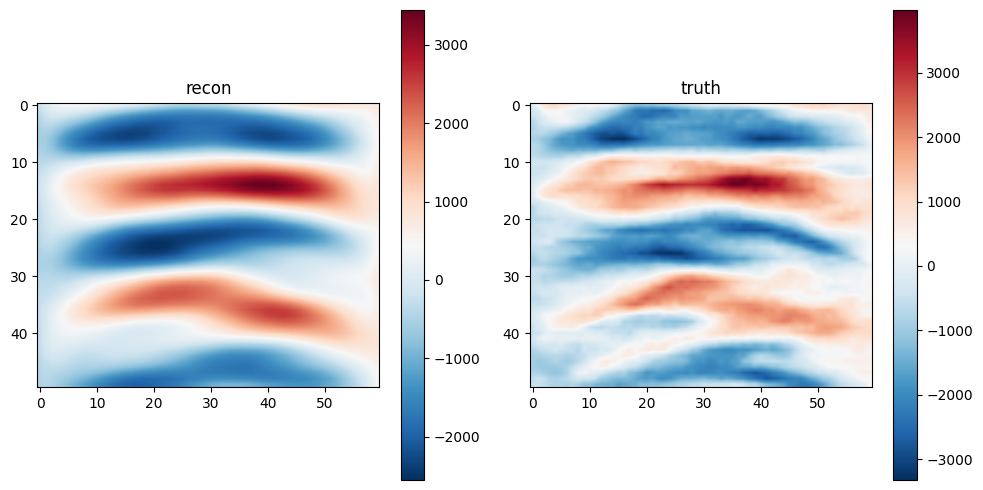

Compare Jey:


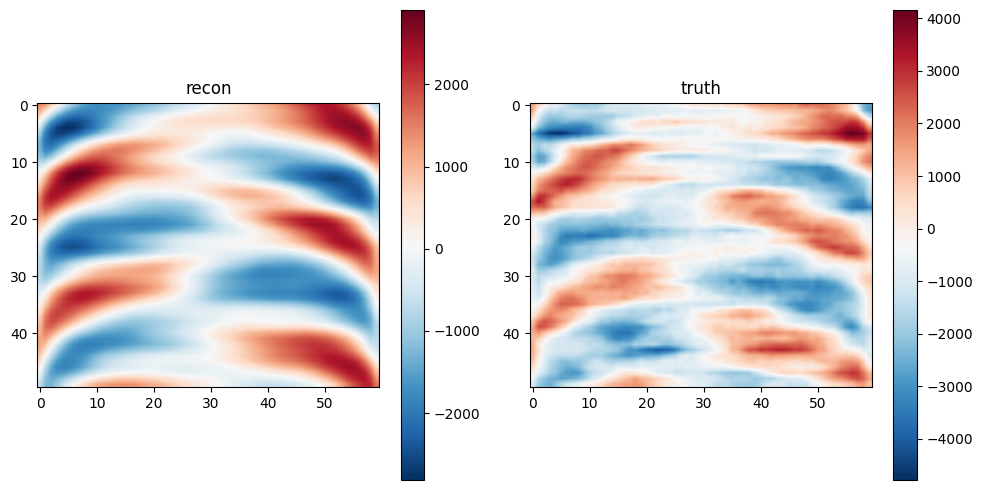

Compare Jez:


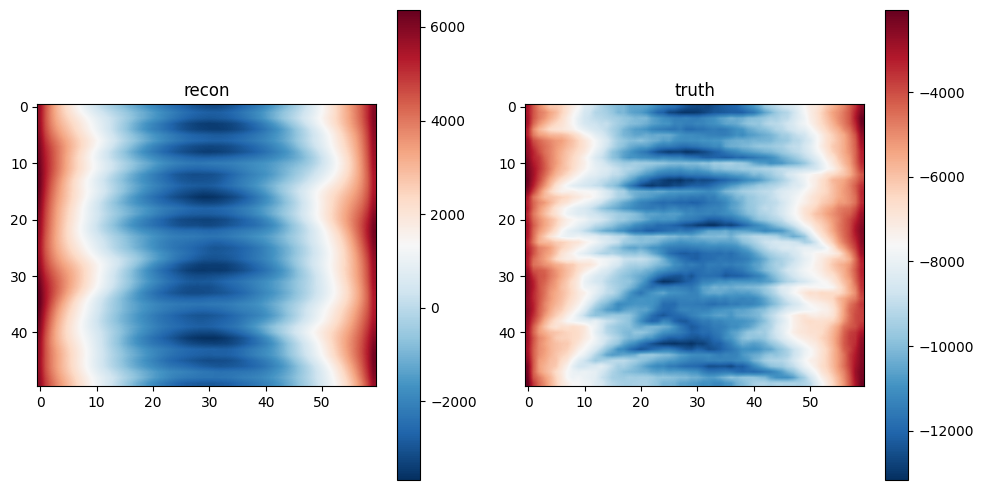

In [95]:
### Plot recon vs. truth at a single timestep
recon_timestep = 1945
jex_recon = recon.recon_dict['Jex'][:,:,np.where(recon.time == recon_timestep)[0][0]]
jey_recon = recon.recon_dict['Jey'][:,:,np.where(recon.time == recon_timestep)[0][0]]
jez_recon = recon.recon_dict['Jez'][:,:,np.where(recon.time == recon_timestep)[0][0]]
print('Compare Jex:')
plot_recon_vs_truth(jex_recon, plasma_data['Jex'][:,:,recon_timestep])
print('Compare Jey:')
plot_recon_vs_truth(jey_recon, plasma_data['Jey'][:,:,recon_timestep])
print('Compare Jez:')
plot_recon_vs_truth(jez_recon, plasma_data['Jez'][:,:,recon_timestep])

In [96]:
######## Plot without lags included ###############################
# for i in range (all_sensor_data.shape[0]):
#     truth = all_sensor_data[i,start:end+1]
#     # recon_in = recon.sensor_measurements[i, np.where(recon.time==start)[0][0]:np.where(recon.time==end)[0][0]+1]
#     recon_in = recon.sensor_measurements[i, np.where(recon.time==start)[0][0]+ lags:np.where(recon.time==end)[0][0]+ lags+1]
#     recon_out = recon.recon_dict['sensors'][i, np.where(recon.time==start)[0][0]:np.where(recon.time==end)[0][0]+1]
#     plt.figure()
#     # Plot truth, recon_in, and recon_out on the same plot
#     plt.plot(truth, label='Truth', color='orange', linestyle='--', linewidth=3)
#     plt.plot(recon_in, label='Recon In', color='blue', linestyle=':', linewidth=3)
#     plt.plot(recon_out, label='Recon Out', color='red', linestyle=':', linewidth=3)
#     # Add labels and legend
#     plt.xlabel('Timestep')
#     plt.ylabel('Sensor Measurement')
#     plt.title(f'Sensor {i} Data Comparison')
#     plt.legend()
#     # Display the plot
#     plt.tight_layout()
#     plt.show()


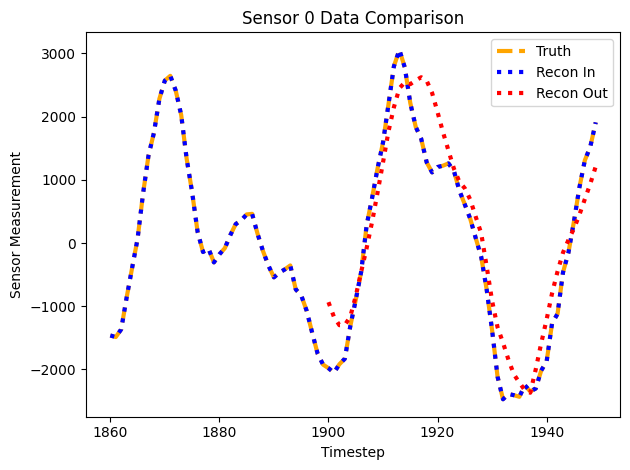

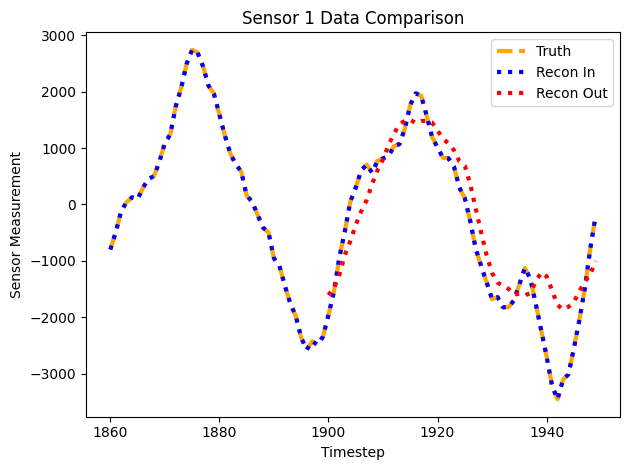

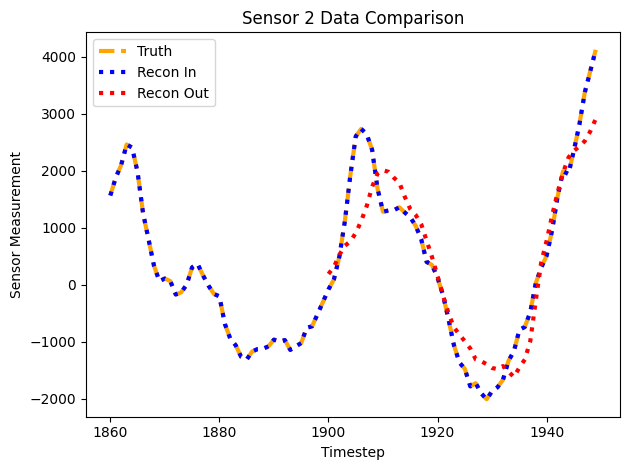

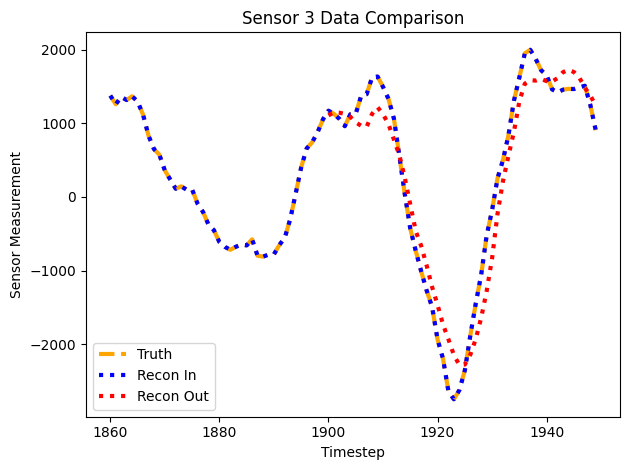

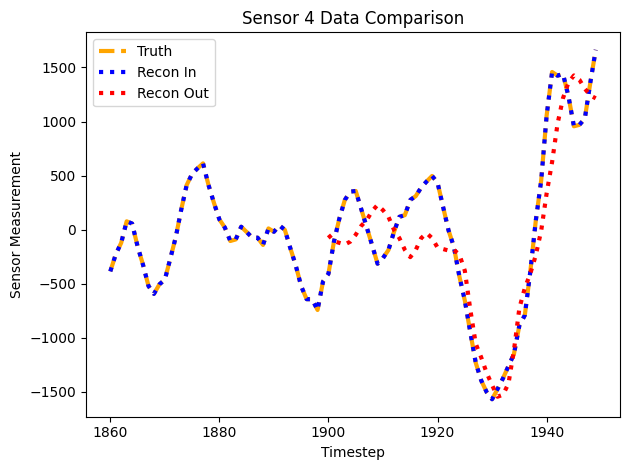

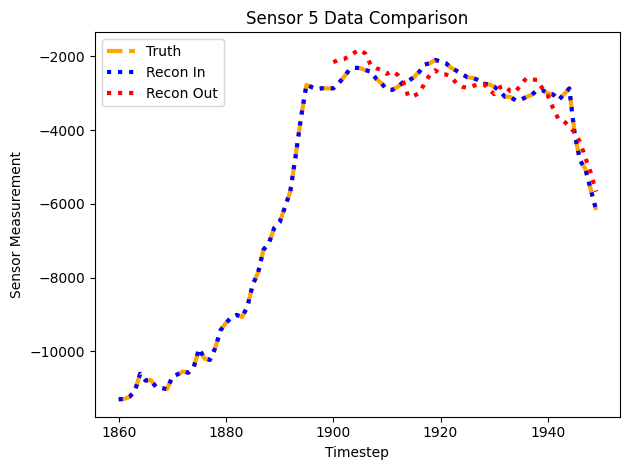

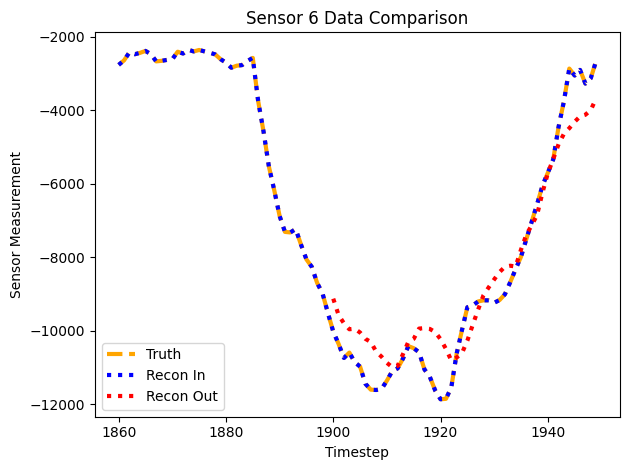

In [97]:
######## Plot with lags included ###############################
lags = 40
for i in range (all_sensor_data.shape[0]):
    truth = all_sensor_data[i,start - lags:end+1]
    # recon_in = recon.sensor_measurements[i, np.where(recon.time==start)[0][0]+ lags:np.where(recon.time==end)[0][0]+ lags+1]
    recon_in = recon.sensor_measurements[i]
    recon_out = recon.recon_dict['sensors'][i, np.where(recon.time==start)[0][0]:np.where(recon.time==end)[0][0]+1]
    plt.figure()
    # Plot truth, recon_in, and recon_out on the same plot
    plt.plot(range(start - lags, end + 1, shred._time[1] - shred._time[0]), truth, label='Truth', color='orange', linestyle='--', linewidth=3)
    plt.plot(range(start - lags, end + 1, shred._time[1] - shred._time[0]),recon_in, label='Recon In', color='blue', linestyle=':', linewidth=3)
    plt.plot(range(start, end + 1, shred._time[1] - shred._time[0]),recon_out, label='Recon Out', color='red', linestyle=':', linewidth=3)
    # Add labels and legend
    plt.xlabel('Timestep')
    plt.ylabel('Sensor Measurement')
    plt.title(f'Sensor {i} Data Comparison')
    plt.legend()
    # Display the plot
    plt.tight_layout()
    plt.show()


In [98]:
### Predict (out-of-sample reconstruction without additional sensor data)
start = 1950
end = 1999
recon = shred.predict(start = start, end = end)

Compare Jex:


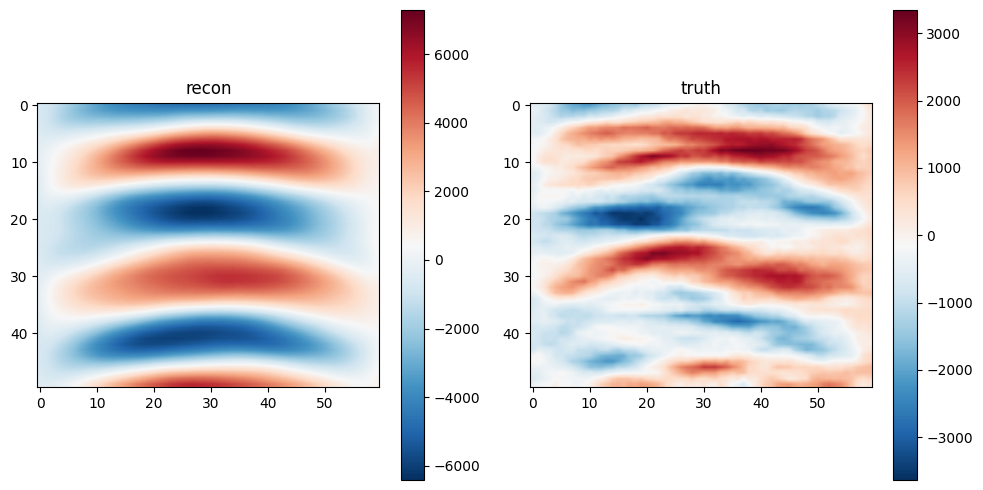

Compare Jey:


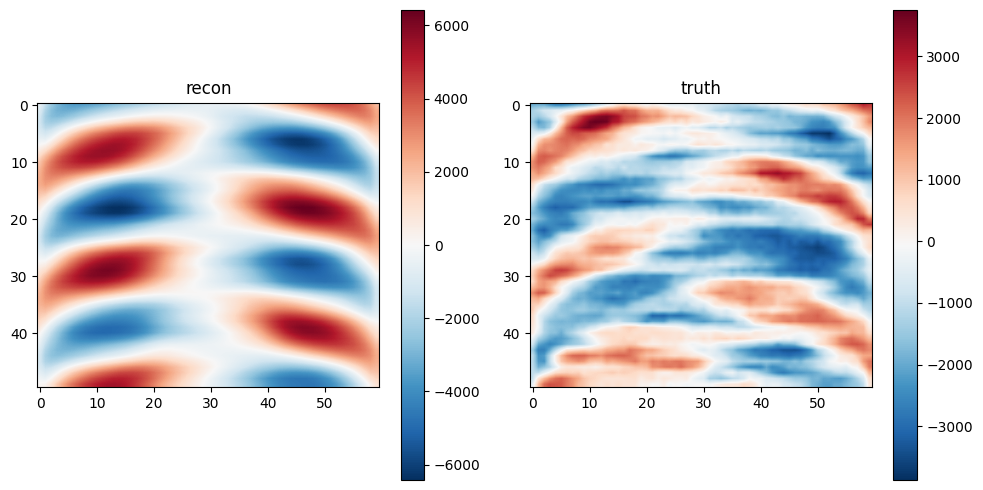

Compare Jez:


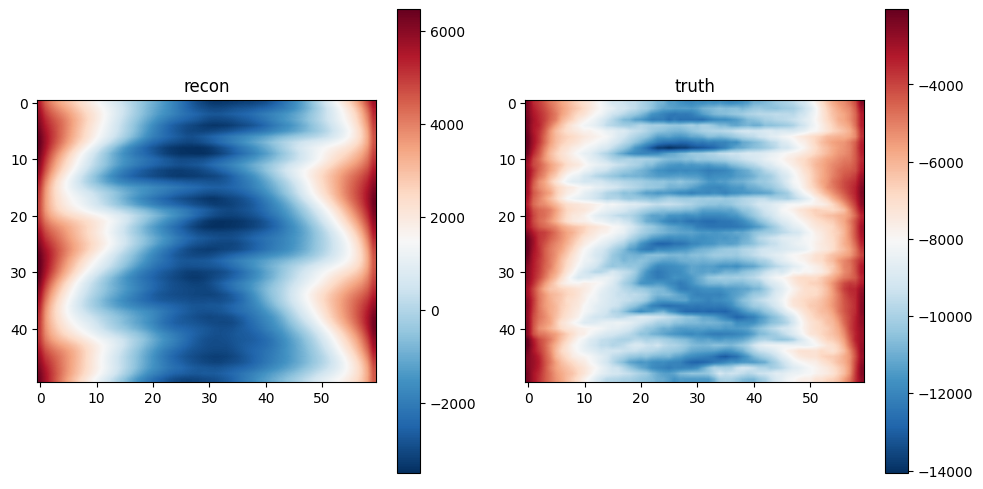

In [99]:
# Plot recon vs. truth at a single timestep
recon_timestep = 1960
jex_recon = recon.recon_dict['Jex'][:,:,np.where(recon.time == recon_timestep)[0][0]]
jey_recon = recon.recon_dict['Jey'][:,:,np.where(recon.time == recon_timestep)[0][0]]
jez_recon = recon.recon_dict['Jez'][:,:,np.where(recon.time == recon_timestep)[0][0]]
print('Compare Jex:')
plot_recon_vs_truth(jex_recon, plasma_data['Jex'][:,:,recon_timestep])
print('Compare Jey:')
plot_recon_vs_truth(jey_recon, plasma_data['Jey'][:,:,recon_timestep])
print('Compare Jez:')
plot_recon_vs_truth(jez_recon, plasma_data['Jez'][:,:,recon_timestep])

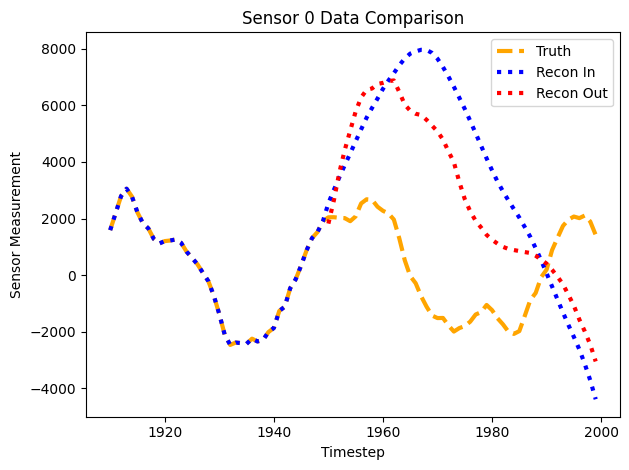

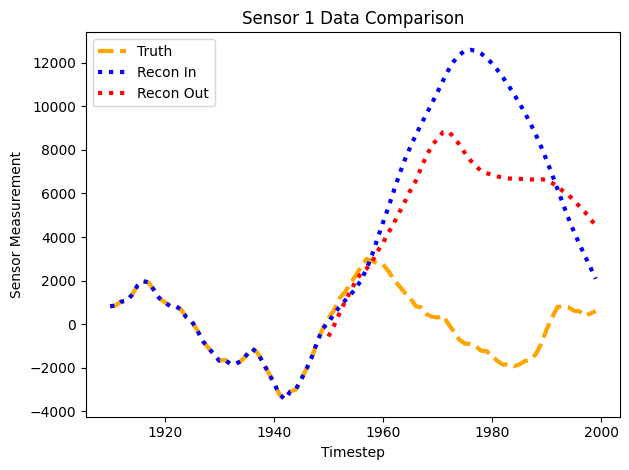

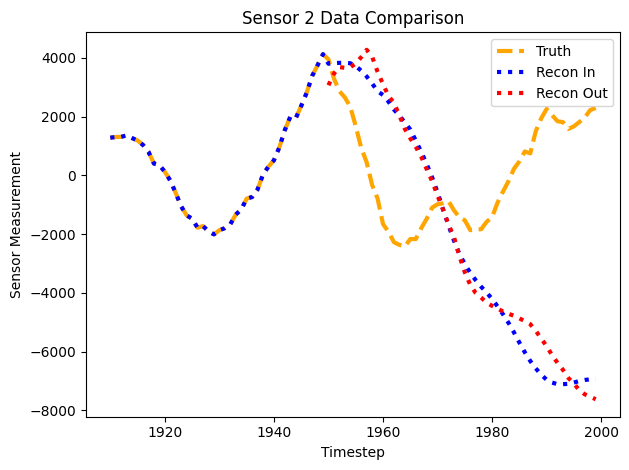

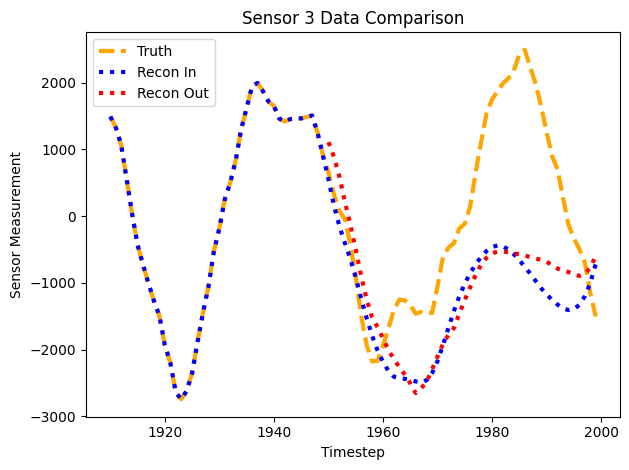

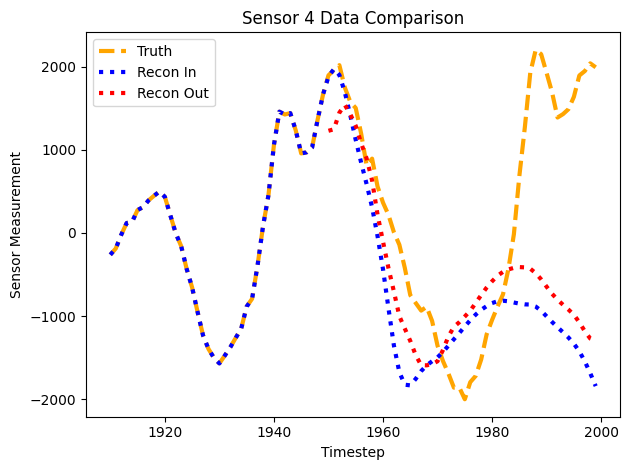

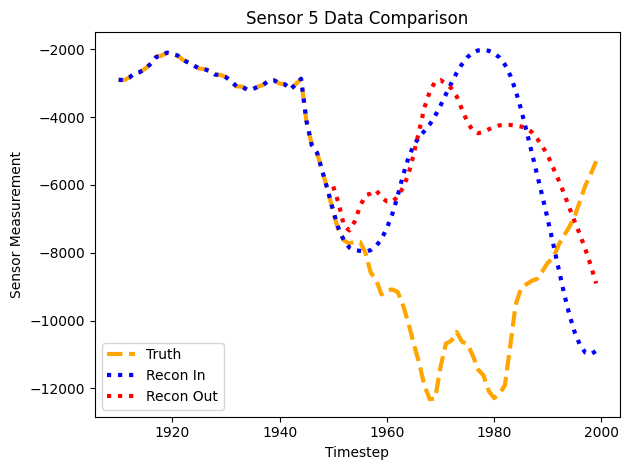

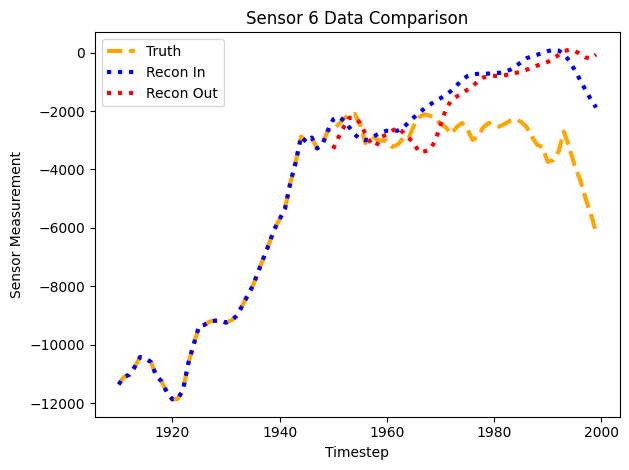

In [100]:
######## Plot with lags included ###############################
for i in range (all_sensor_data.shape[0]):
    truth = all_sensor_data[i,start - lags:end+1]
    # recon_in = recon.sensor_measurements[i, np.where(recon.time==start)[0][0]+ lags:np.where(recon.time==end)[0][0]+ lags+1]
    recon_in = recon.sensor_measurements[i]
    recon_out = recon.recon_dict['sensors'][i, np.where(recon.time==start)[0][0]:np.where(recon.time==end)[0][0]+1]
    plt.figure()
    # Plot truth, recon_in, and recon_out on the same plot
    plt.plot(range(start - lags, end + 1, shred._time[1] - shred._time[0]), truth, label='Truth', color='orange', linestyle='--', linewidth=3)
    plt.plot(range(start - lags, end + 1, shred._time[1] - shred._time[0]),recon_in, label='Recon In', color='blue', linestyle=':', linewidth=3)
    plt.plot(range(start, end + 1, shred._time[1] - shred._time[0]),recon_out, label='Recon Out', color='red', linestyle=':', linewidth=3)
    # Add labels and legend
    plt.xlabel('Timestep')
    plt.ylabel('Sensor Measurement')
    plt.title(f'Sensor {i} Data Comparison')
    plt.legend()
    # Display the plot
    plt.tight_layout()
    plt.show()



In [101]:
### Predict (out-of-sample with additional sensor data)
start = 1950
end = 1999
recon = shred.predict(start = start, end = end, sensor_data=all_sensor_data, sensor_data_time=np.arange(0,timesteps))

Compare Jex:


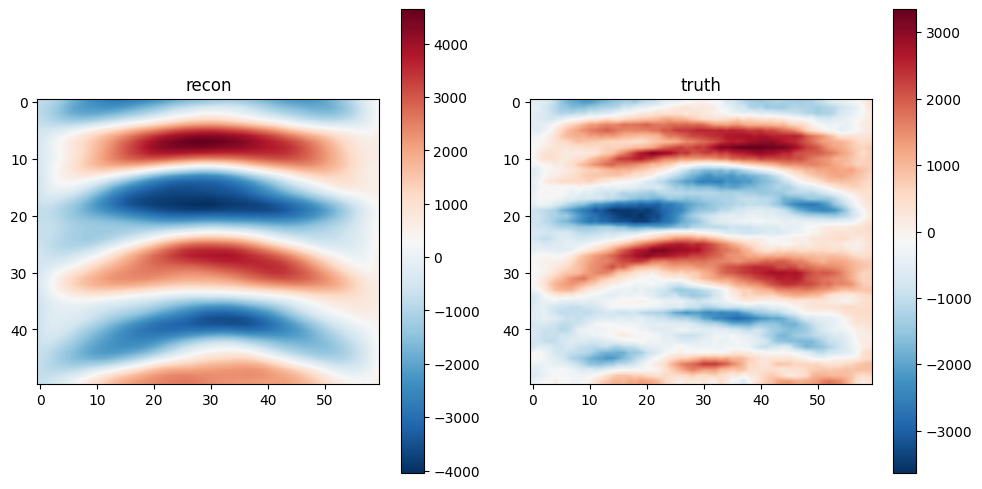

Compare Jey:


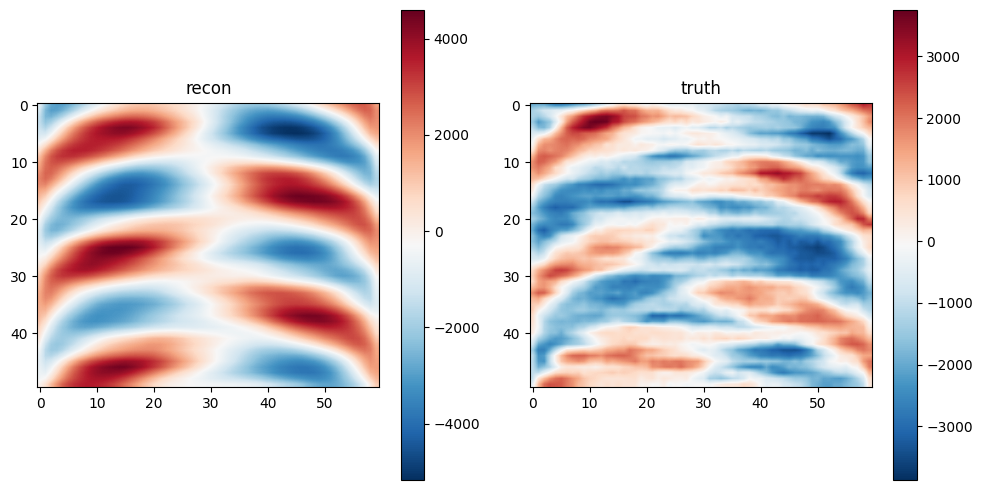

Compare Jez:


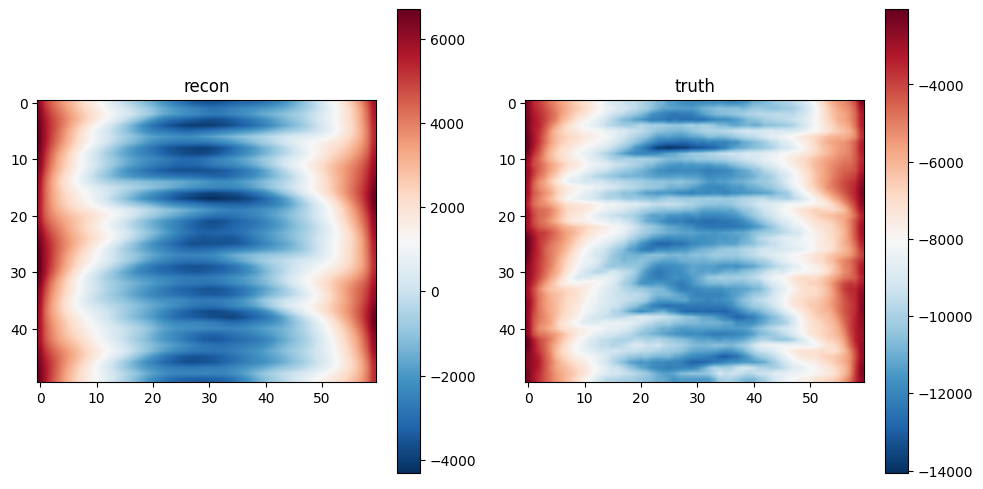

In [102]:
recon_timestep = 1960
jex_recon = recon.recon_dict['Jex'][:,:,np.where(recon.time == recon_timestep)[0][0]]
jey_recon = recon.recon_dict['Jey'][:,:,np.where(recon.time == recon_timestep)[0][0]]
jez_recon = recon.recon_dict['Jez'][:,:,np.where(recon.time == recon_timestep)[0][0]]
print('Compare Jex:')
plot_recon_vs_truth(jex_recon, plasma_data['Jex'][:,:,recon_timestep])
print('Compare Jey:')
plot_recon_vs_truth(jey_recon, plasma_data['Jey'][:,:,recon_timestep])
print('Compare Jez:')
plot_recon_vs_truth(jez_recon, plasma_data['Jez'][:,:,recon_timestep])

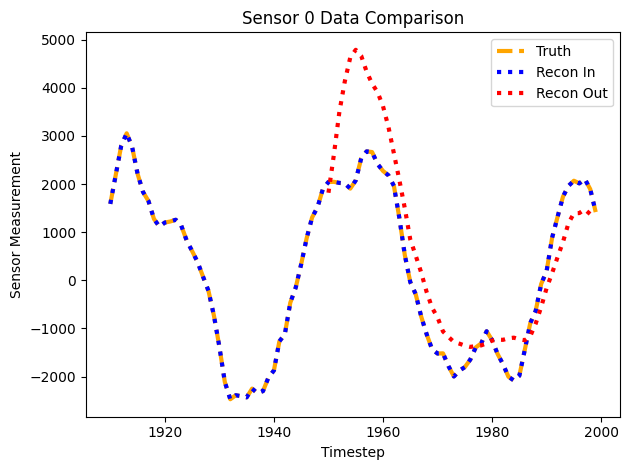

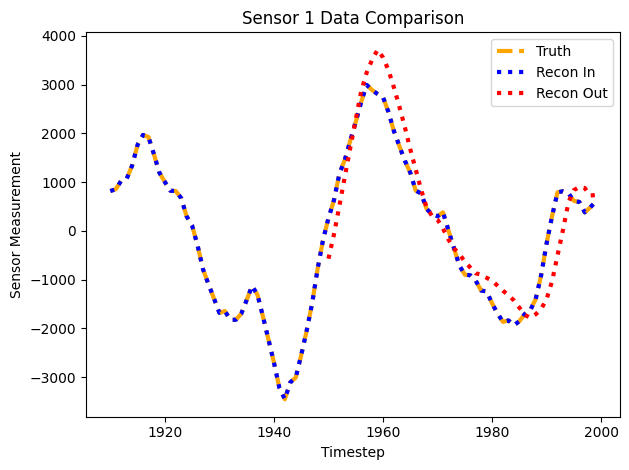

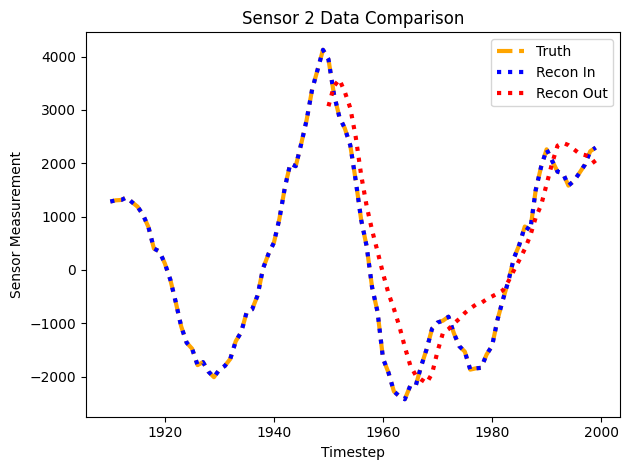

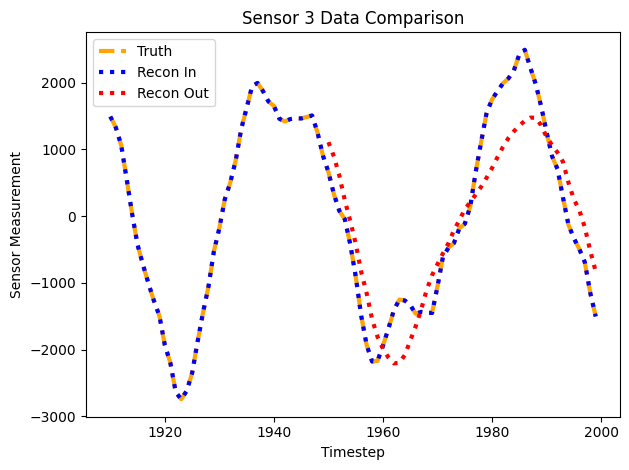

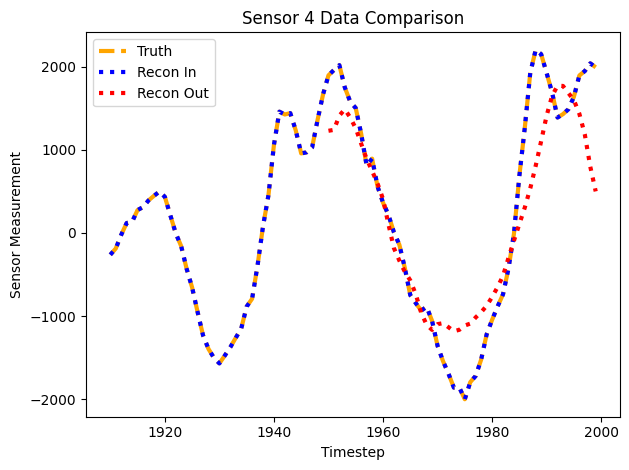

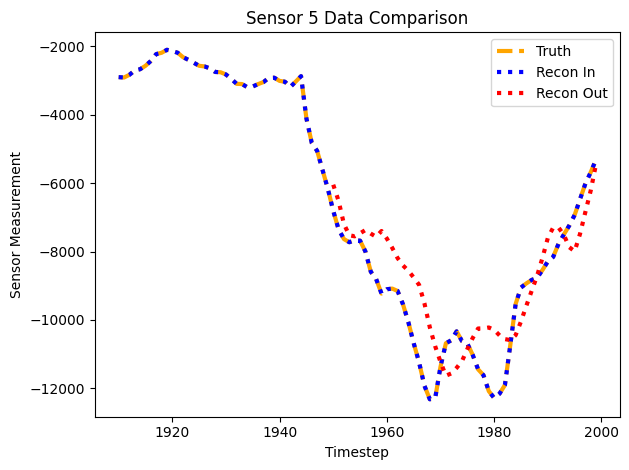

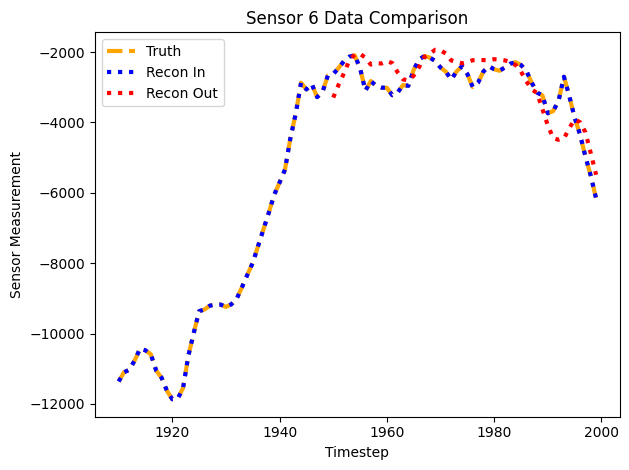

In [103]:
for i in range (all_sensor_data.shape[0]):
    truth = all_sensor_data[i,start - lags:end+1]
    # recon_in = recon.sensor_measurements[i, np.where(recon.time==start)[0][0]+ lags:np.where(recon.time==end)[0][0]+ lags+1]
    recon_in = recon.sensor_measurements[i]
    recon_out = recon.recon_dict['sensors'][i, np.where(recon.time==start)[0][0]:np.where(recon.time==end)[0][0]+1]
    plt.figure()
    # Plot truth, recon_in, and recon_out on the same plot
    plt.plot(range(start - lags, end + 1, shred._time[1] - shred._time[0]), truth, label='Truth', color='orange', linestyle='--', linewidth=3)
    plt.plot(range(start - lags, end + 1, shred._time[1] - shred._time[0]),recon_in, label='Recon In', color='blue', linestyle=':', linewidth=3)
    plt.plot(range(start, end + 1, shred._time[1] - shred._time[0]),recon_out, label='Recon Out', color='red', linestyle=':', linewidth=3)
    # Add labels and legend
    plt.xlabel('Timestep')
    plt.ylabel('Sensor Measurement')
    plt.title(f'Sensor {i} Data Comparison')
    plt.legend()
    # Display the plot
    plt.tight_layout()
    plt.show()



### Recon (uses only the sensor measurements passed in to perform reconstructions)

In [104]:
### Recon: performs full-state reconstructin using only the provided sensor_measurements.
recon = shred.recon(all_sensor_data[:,0:training_timesteps]) # number of reconstructions equals length of sensor data minus lags

Compare Jex:


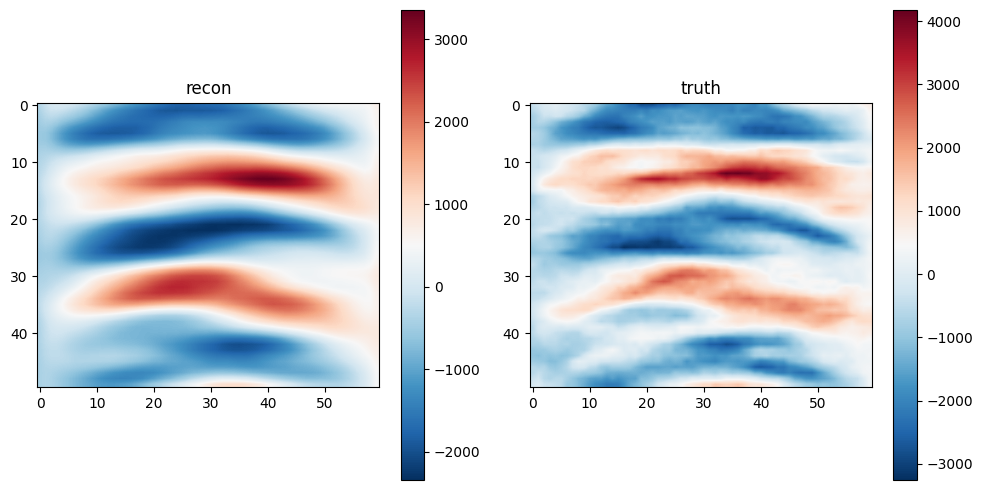

Compare Jey:


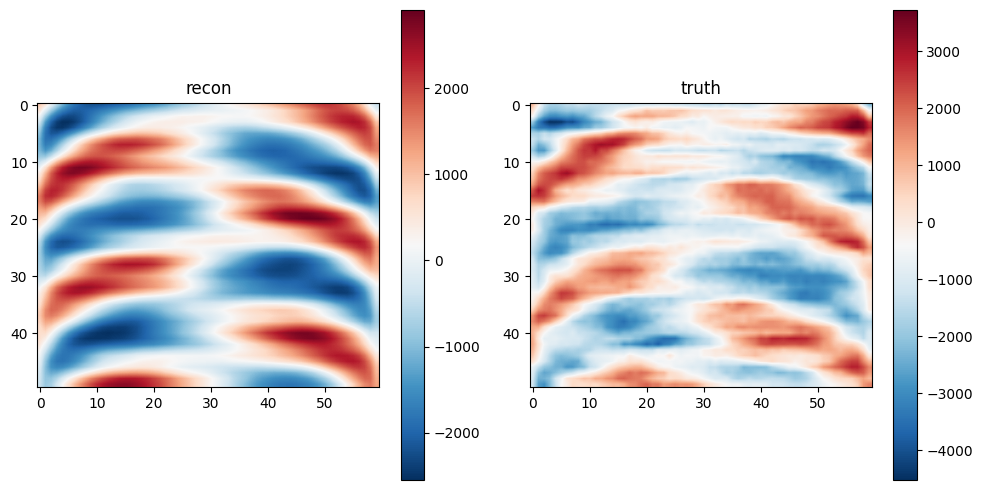

Compare Jez:


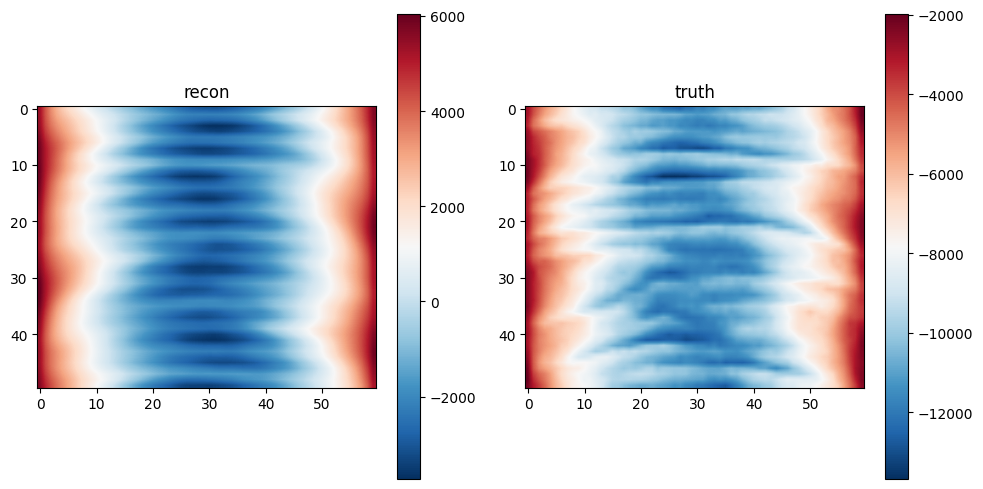

In [105]:
recon_index = 1909
jex_recon = recon['Jex'][:,:,recon_index]
jey_recon = recon['Jey'][:,:,recon_index]
jez_recon = recon['Jez'][:,:,recon_index]
print('Compare Jex:')
plot_recon_vs_truth(jex_recon, plasma_data['Jex'][:,:,recon_index+lags])
print('Compare Jey:')
plot_recon_vs_truth(jey_recon, plasma_data['Jey'][:,:,recon_index+lags])
print('Compare Jez:')
plot_recon_vs_truth(jez_recon, plasma_data['Jez'][:,:,recon_index+lags])

C:\Users\David\AppData\Local\Temp\ipykernel_72760\3802679832.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.title(f'Sensor: {shred.sensor_summary.iloc[i][1]} {shred.sensor_summary.iloc[i][2]}')


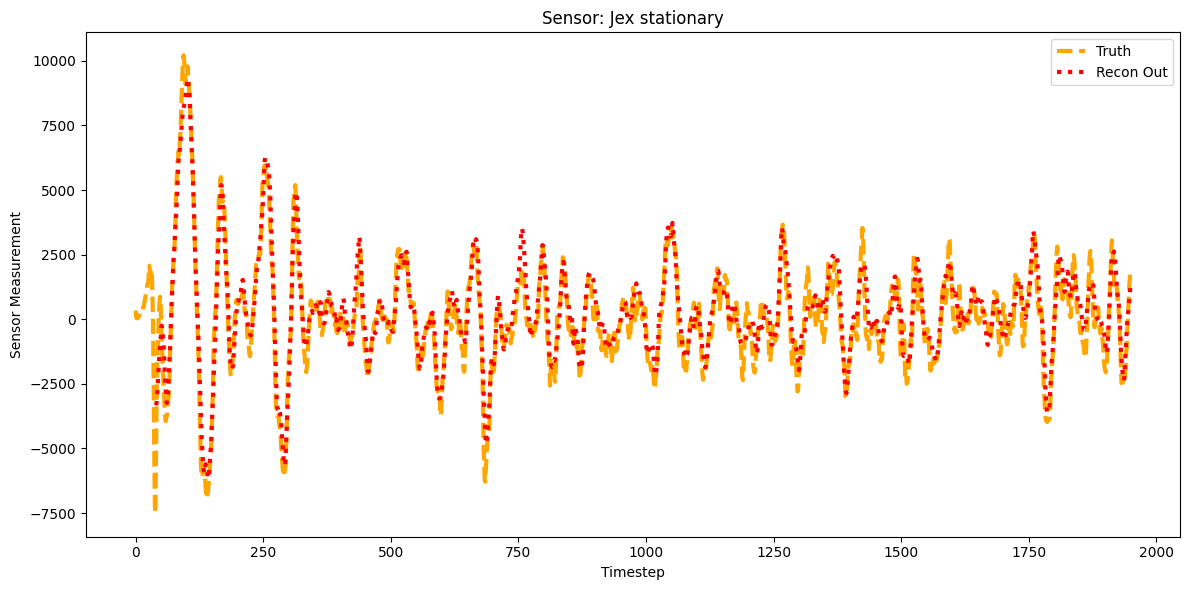

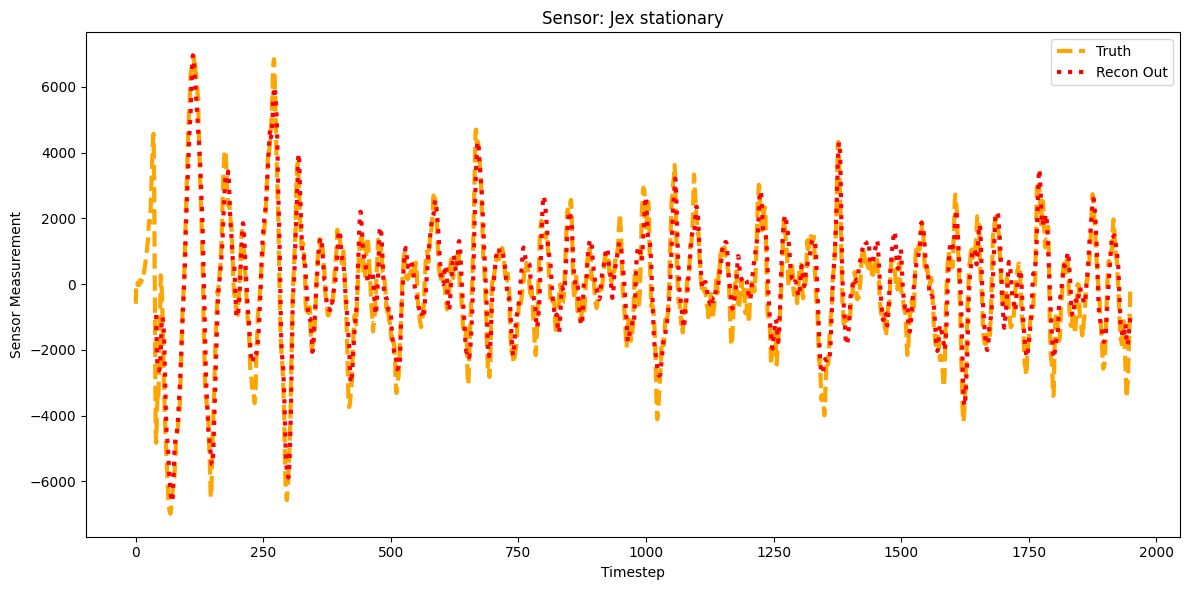

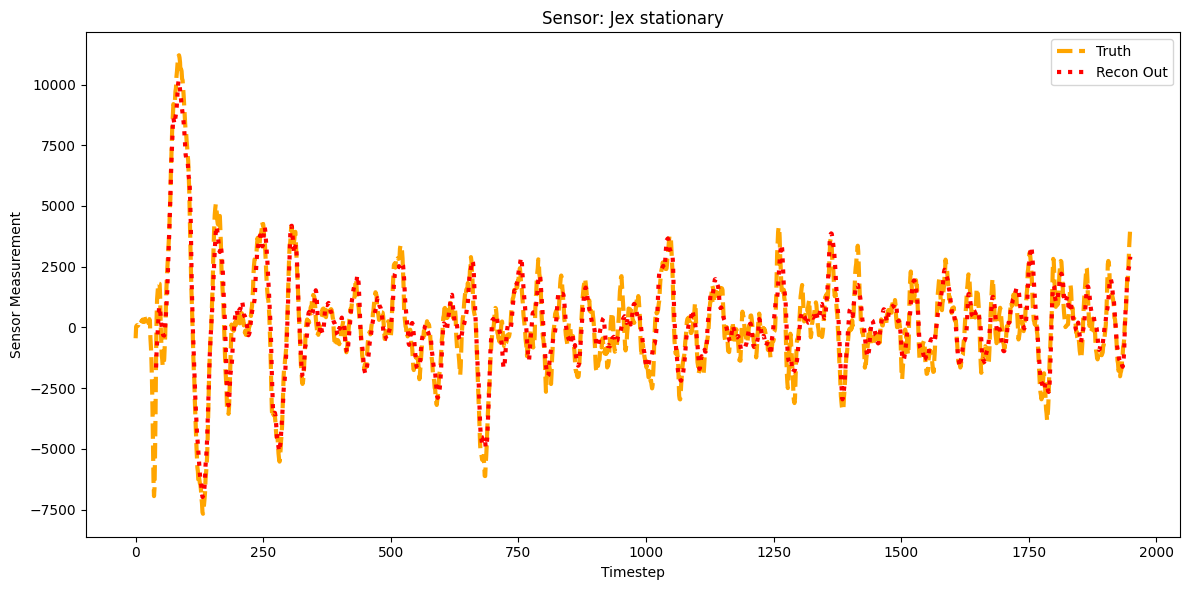

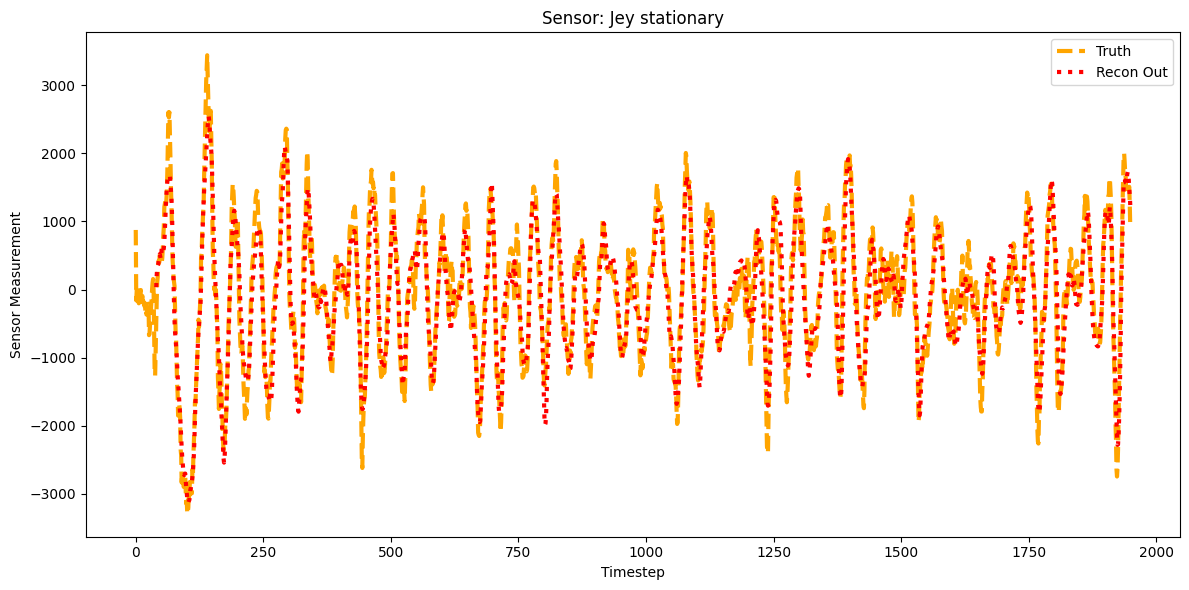

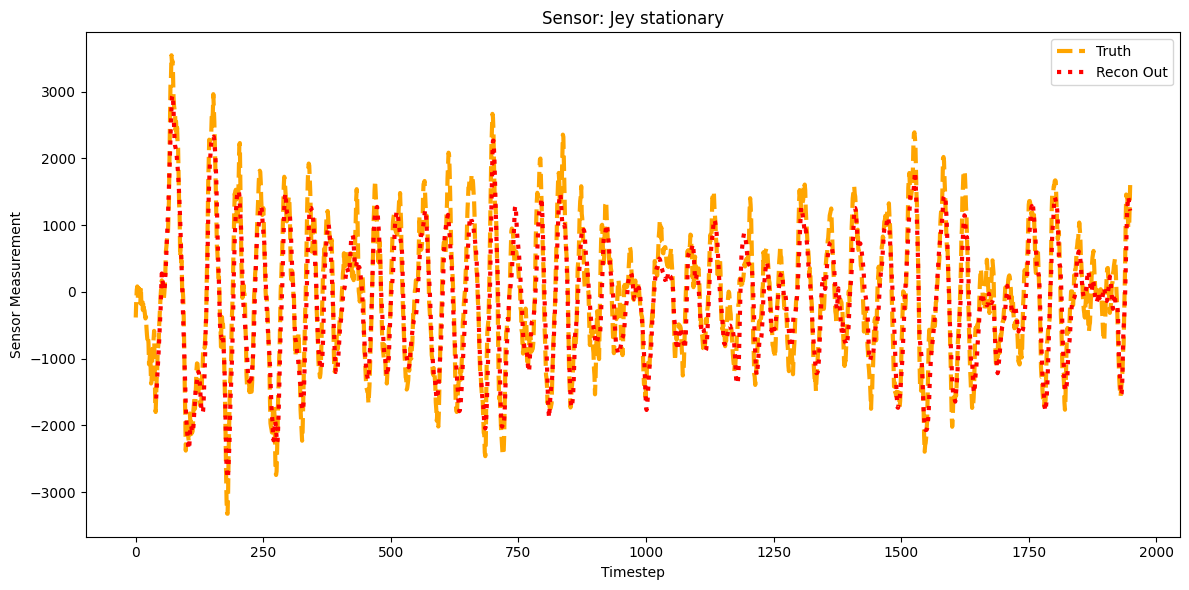

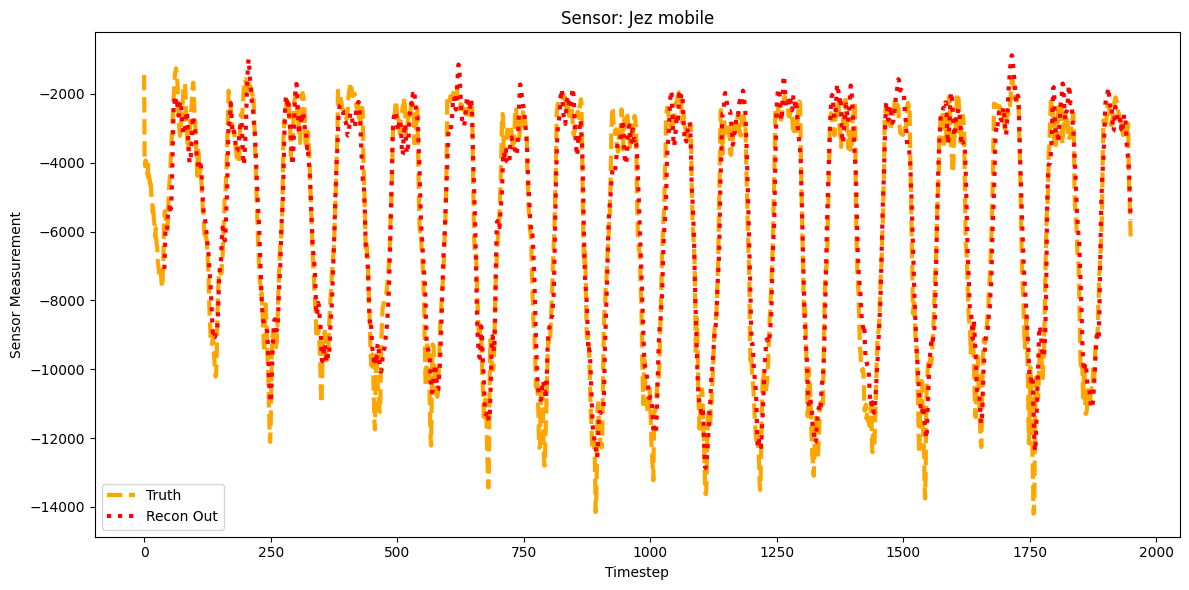

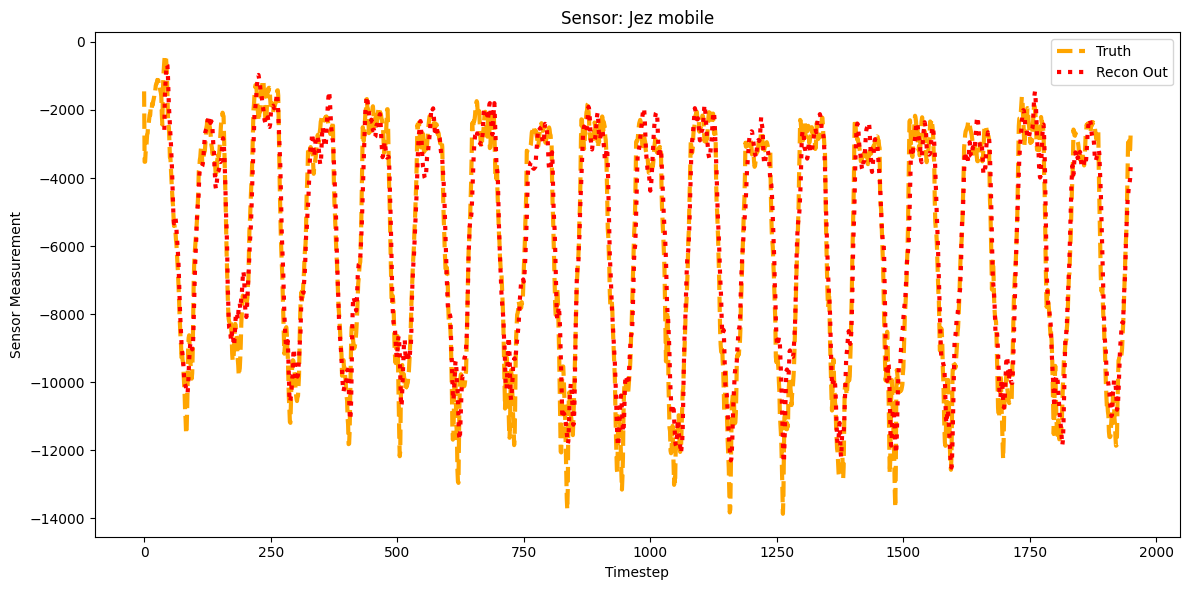

In [106]:
for i in range (all_sensor_data.shape[0]):
    truth = all_sensor_data[i,0:training_timesteps]
    # recon_in = recon.sensor_measurements[i, np.where(recon.time==start)[0][0]+ lags:np.where(recon.time==end)[0][0]+ lags+1]
    # recon_in = recon.sensor_measurements[i]
    recon_out = recon['sensors'][i]
    plt.figure(figsize=(12, 6))
    # Plot truth, recon_in, and recon_out on the same plot
    plt.plot(range(shred._time[0], shred._time[-1] + 1, shred._time[1] - shred._time[0]), truth, label='Truth', color='orange', linestyle='--', linewidth=3)
    # plt.plot(range(start - lags, end + 1, shred._time[1] - shred._time[0]),recon_in, label='Recon In', color='blue', linestyle=':', linewidth=3)
    plt.plot(range(np.where(shred._time==lags)[0][0], shred._time[-1] + 1, shred._time[1] - shred._time[0]),recon_out, label='Recon Out', color='red', linestyle=':', linewidth=3)
    # Add labels and legend
    plt.xlabel('Timestep')
    plt.ylabel('Sensor Measurement')
    plt.title(f'Sensor: {shred.sensor_summary.iloc[i][1]} {shred.sensor_summary.iloc[i][2]}')
    plt.legend()
    # Display the plot
    plt.tight_layout()
    plt.show()



In [107]:
### Forecast (no additional sensor data): forecasts the high-dimensional state space `timesteps` into the future.
# It is a convnience wrapper around `predict(self, start)` for forecasts (out-of-sample reconstructions).

recon = shred.forecast(50)

Compare Jex:


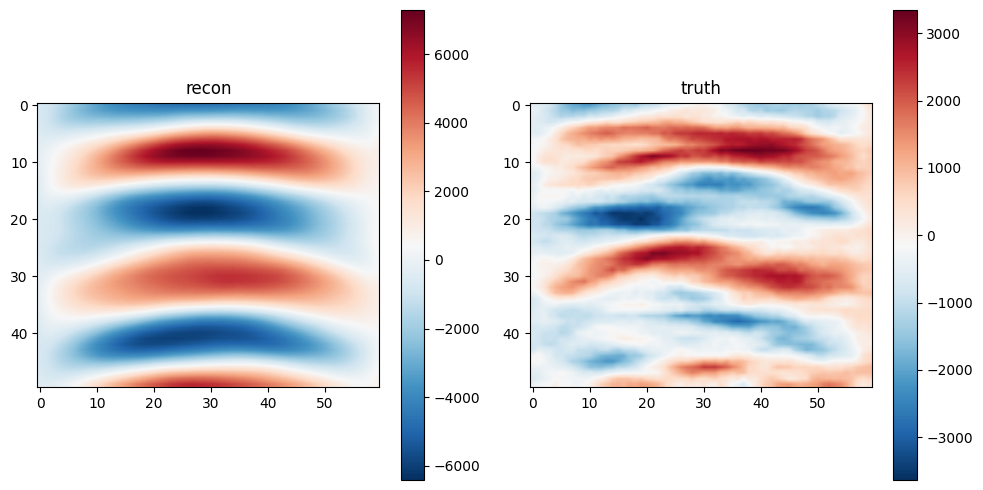

Compare Jey:


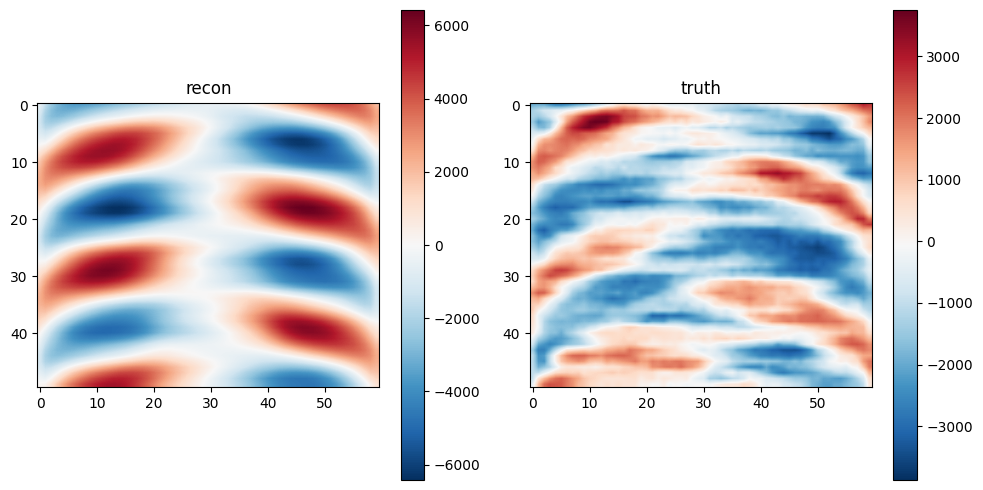

Compare Jez:


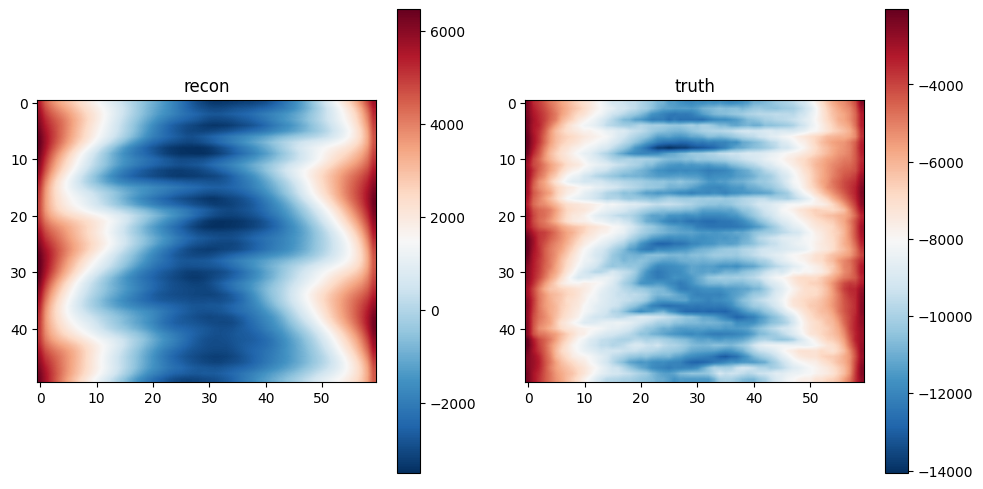

In [108]:
recon_timestep = 1960
jex_recon = recon.recon_dict['Jex'][:,:,np.where(recon.time == recon_timestep)[0][0]]
jey_recon = recon.recon_dict['Jey'][:,:,np.where(recon.time == recon_timestep)[0][0]]
jez_recon = recon.recon_dict['Jez'][:,:,np.where(recon.time == recon_timestep)[0][0]]
print('Compare Jex:')
plot_recon_vs_truth(jex_recon, plasma_data['Jex'][:,:,recon_timestep])
print('Compare Jey:')
plot_recon_vs_truth(jey_recon, plasma_data['Jey'][:,:,recon_timestep])
print('Compare Jez:')
plot_recon_vs_truth(jez_recon, plasma_data['Jez'][:,:,recon_timestep])

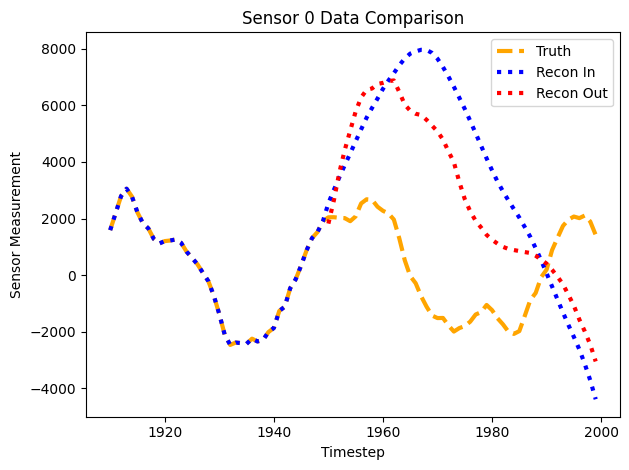

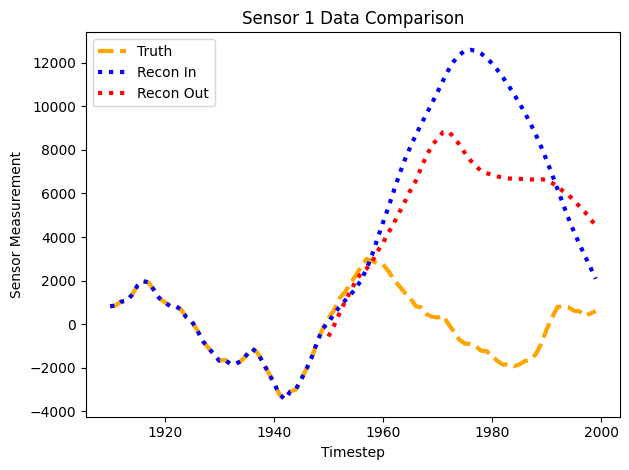

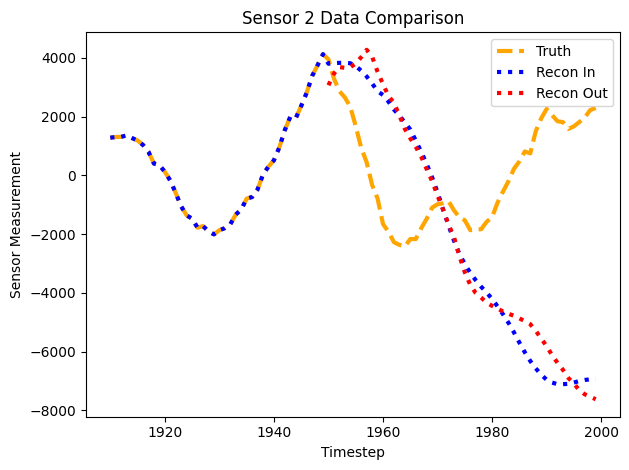

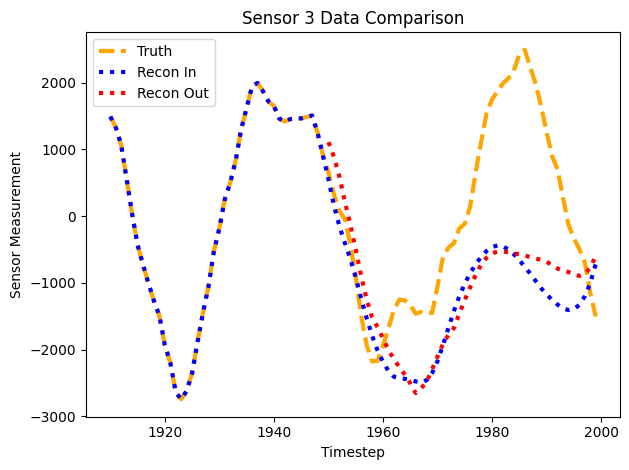

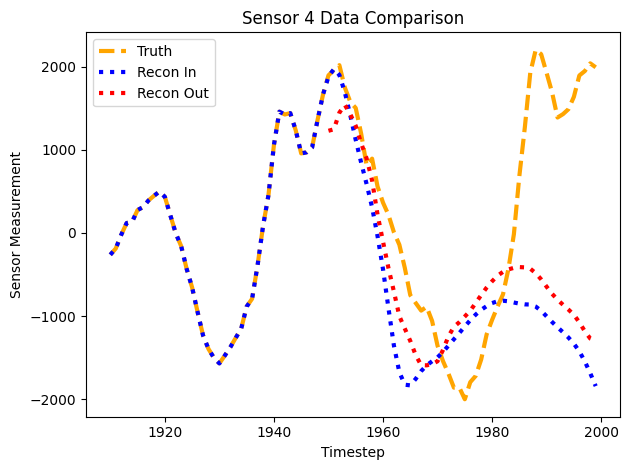

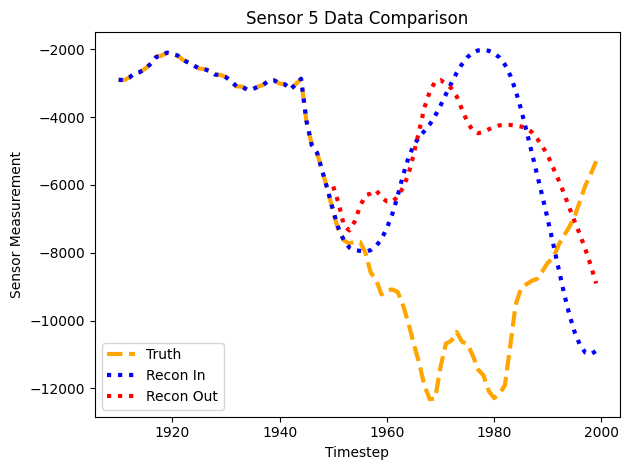

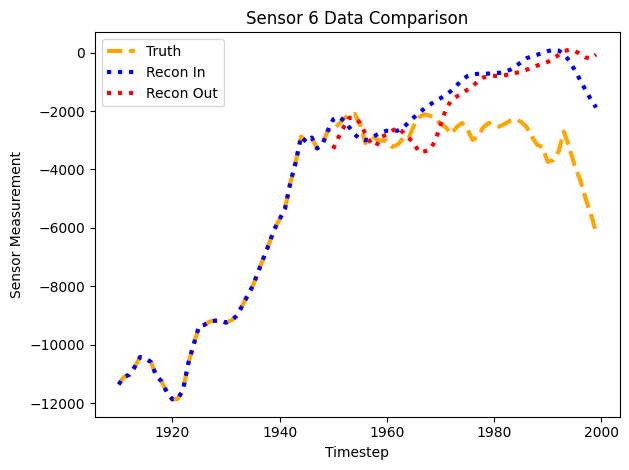

In [109]:
start = recon.time[0]
end = recon.time[-1]
######## Plot with lags included ###############################
for i in range (all_sensor_data.shape[0]):
    truth = all_sensor_data[i,start - lags:end+1]
    # recon_in = recon.sensor_measurements[i, np.where(recon.time==start)[0][0]+ lags:np.where(recon.time==end)[0][0]+ lags+1]
    recon_in = recon.sensor_measurements[i]
    recon_out = recon.recon_dict['sensors'][i, np.where(recon.time==start)[0][0]:np.where(recon.time==end)[0][0]+1]
    plt.figure()
    # Plot truth, recon_in, and recon_out on the same plot
    plt.plot(range(start - lags, end + 1, shred._time[1] - shred._time[0]), truth, label='Truth', color='orange', linestyle='--', linewidth=3)
    plt.plot(range(start - lags, end + 1, shred._time[1] - shred._time[0]),recon_in, label='Recon In', color='blue', linestyle=':', linewidth=3)
    plt.plot(range(start, end + 1, shred._time[1] - shred._time[0]),recon_out, label='Recon Out', color='red', linestyle=':', linewidth=3)
    # Add labels and legend
    plt.xlabel('Timestep')
    plt.ylabel('Sensor Measurement')
    plt.title(f'Sensor {i} Data Comparison')
    plt.legend()
    # Display the plot
    plt.tight_layout()
    plt.show()



In [110]:
### Forecast (with additional sensor data): forecasts the high-dimensional state space `timesteps` into the future.
# It is a convnience wrapper around `predict(self, start)` for forecasts (out-of-sample reconstructions).
recon = shred.forecast(50, sensor_data=all_sensor_data, sensor_data_time=np.arange(0,timesteps))

Compare Jex:


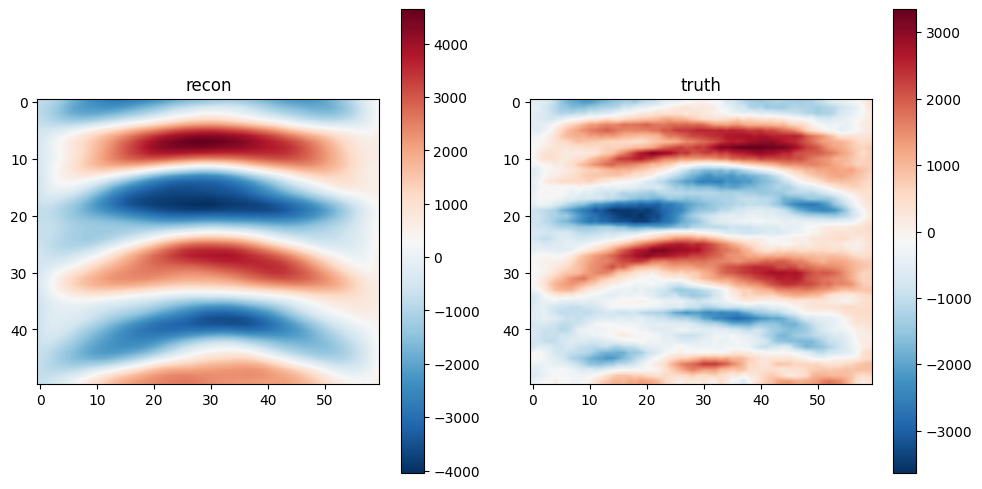

Compare Jey:


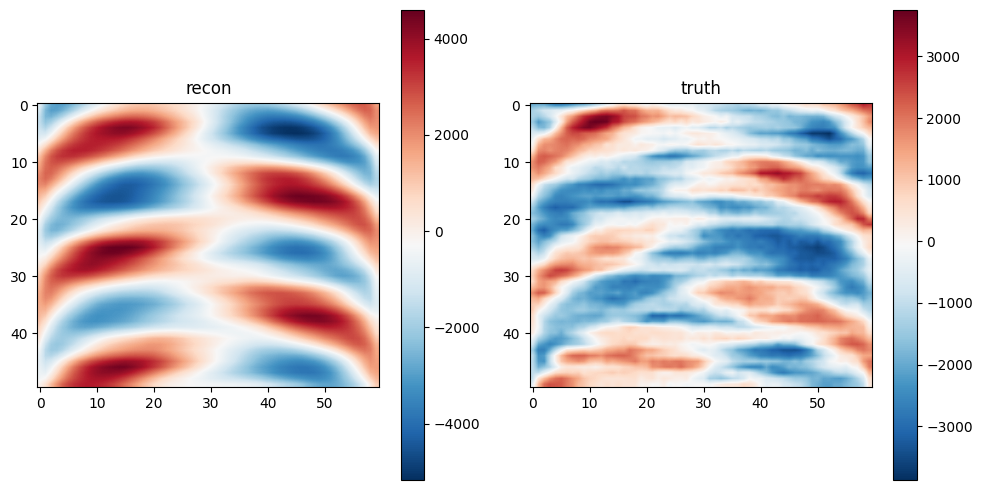

Compare Jez:


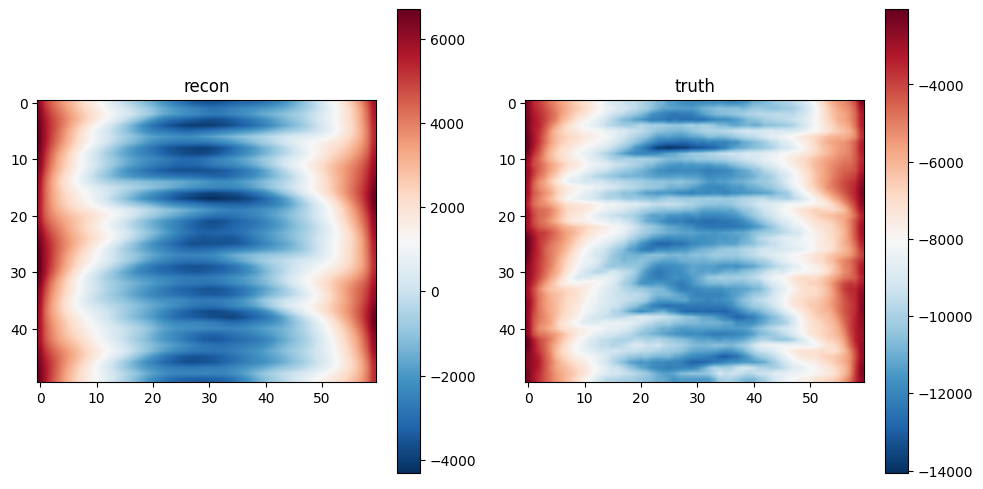

In [111]:
recon_timestep = 1960
jex_recon = recon.recon_dict['Jex'][:,:,np.where(recon.time == recon_timestep)[0][0]]
jey_recon = recon.recon_dict['Jey'][:,:,np.where(recon.time == recon_timestep)[0][0]]
jez_recon = recon.recon_dict['Jez'][:,:,np.where(recon.time == recon_timestep)[0][0]]
print('Compare Jex:')
plot_recon_vs_truth(jex_recon, plasma_data['Jex'][:,:,recon_timestep])
print('Compare Jey:')
plot_recon_vs_truth(jey_recon, plasma_data['Jey'][:,:,recon_timestep])
print('Compare Jez:')
plot_recon_vs_truth(jez_recon, plasma_data['Jez'][:,:,recon_timestep])

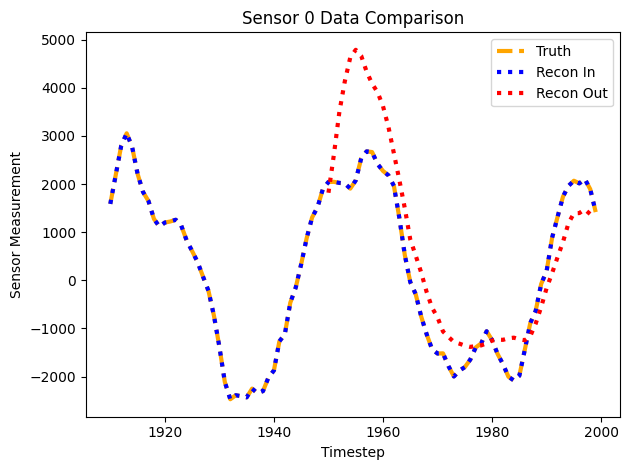

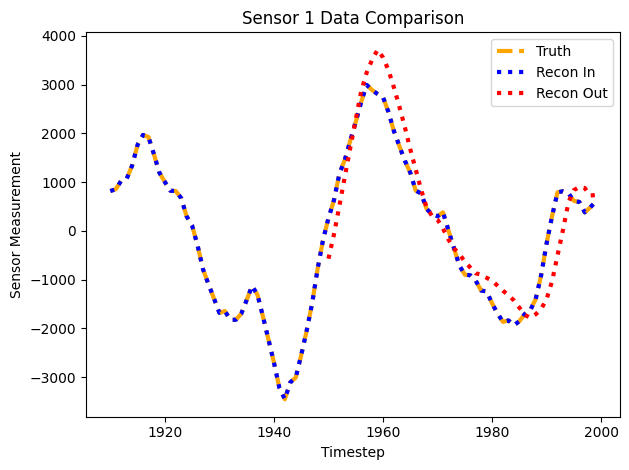

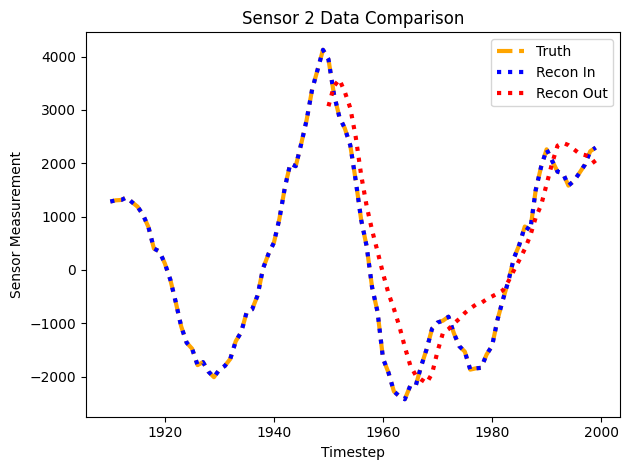

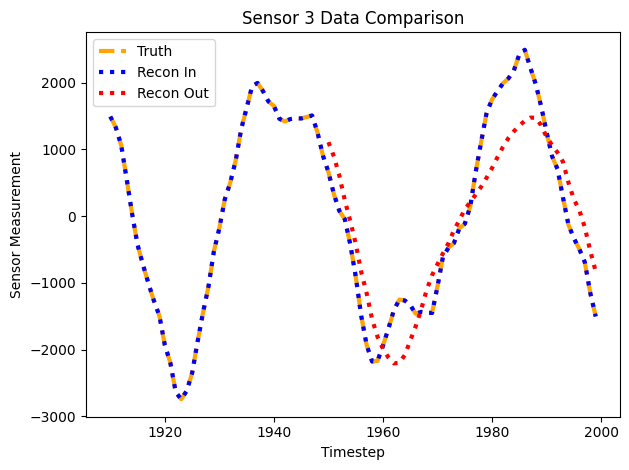

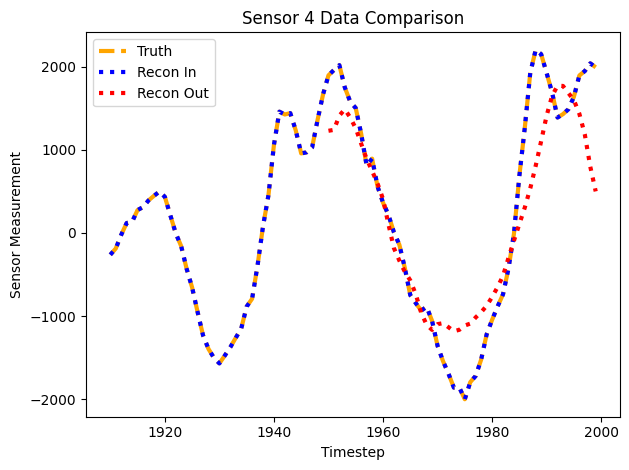

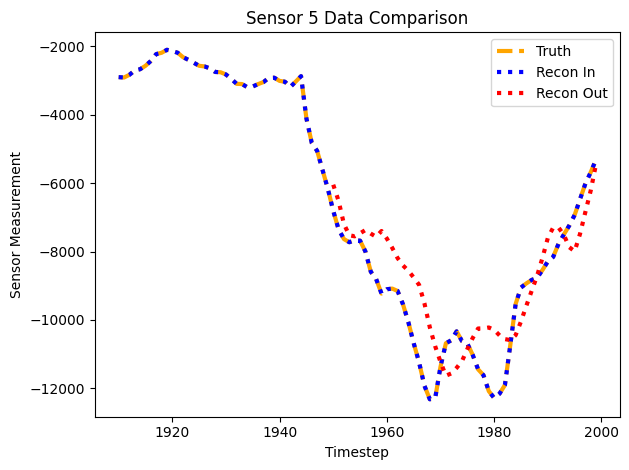

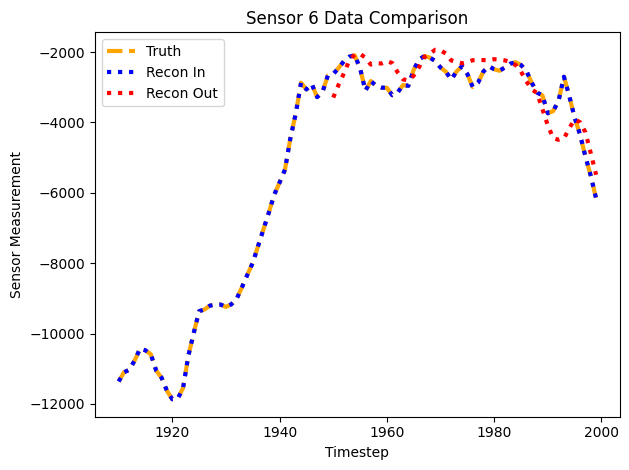

In [112]:
start = recon.time[0]
end = recon.time[-1]
######## Plot with lags included ###############################
for i in range (all_sensor_data.shape[0]):
    truth = all_sensor_data[i,start - lags:end+1]
    # recon_in = recon.sensor_measurements[i, np.where(recon.time==start)[0][0]+ lags:np.where(recon.time==end)[0][0]+ lags+1]
    recon_in = recon.sensor_measurements[i]
    recon_out = recon.recon_dict['sensors'][i, np.where(recon.time==start)[0][0]:np.where(recon.time==end)[0][0]+1]
    plt.figure()
    # Plot truth, recon_in, and recon_out on the same plot
    plt.plot(range(start - lags, end + 1, shred._time[1] - shred._time[0]), truth, label='Truth', color='orange', linestyle='--', linewidth=3)
    plt.plot(range(start - lags, end + 1, shred._time[1] - shred._time[0]),recon_in, label='Recon In', color='blue', linestyle=':', linewidth=3)
    plt.plot(range(start, end + 1, shred._time[1] - shred._time[0]),recon_out, label='Recon Out', color='red', linestyle=':', linewidth=3)
    # Add labels and legend
    plt.xlabel('Timestep')
    plt.ylabel('Sensor Measurement')
    plt.title(f'Sensor {i} Data Comparison')
    plt.legend()
    # Display the plot
    plt.tight_layout()
    plt.show()

